# Homework Sheet No. 1
Due Date: May 17th, 2022
### Submitted by 
- Cholin Kim (1133547)
- Philipp Gehring (1104946)
- Lukas Heimann (1119153)



In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

using TestImages
using Colors, Images
using ImageFiltering
using OffsetArrays
using JLD2
using Plots
using ImageView

  Activating project at `~/Documents/Uni/Semester_2/ViMaM/Exercises/Exercise1/material`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /Users/lukas/Documents/Uni/Semester_2/ViMaM/Exercises/Exercise1/material/Manifest.toml:0
┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1423
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423
┌ Info: Precompiling ImageView [86fae568-95e7-573e-a6b2-d8a6b900c9ef]
└ @ Base loading.jl:1423


# Excercise 1.1
## Code

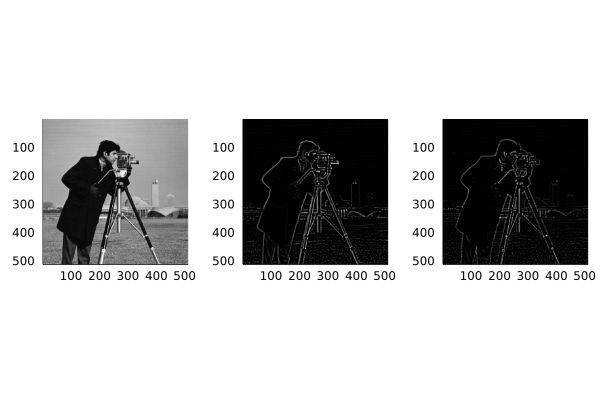

In [2]:
function filter_image(img, kernel)
    img_filtered = imfilter(img, kernel)
    
    # rescale values to [0, 1]
    on_center = max.(img_filtered, 0)
    max_val = maximum(on_center)
    on_center ./= max_val
    
    # rescale values to [0, 1]
    off_center = max.(-img_filtered, 0)
    max_val = maximum(off_center)
    off_center ./= max_val
    
    return (Gray.(on_center), Gray.(off_center))
end

img = testimage("cameraman")
img_on_center, img_off_center = filter_image(img, Kernel.LoG(2))

p_img_g = plot(img)
p_img_gp = plot(img_on_center)
p_img_gm = plot(img_off_center)

plot(p_img_g, p_img_gp, p_img_gm, layout=(1, 3))

## Description
The original image is on the left. This image was filtered with a Laplacian of Gaussian (LoG) kernel and a maximum or minimum filter. On-center, off surround neurons is expressed by maximum filter and vice versa.

# Exercise 1.2
## Code

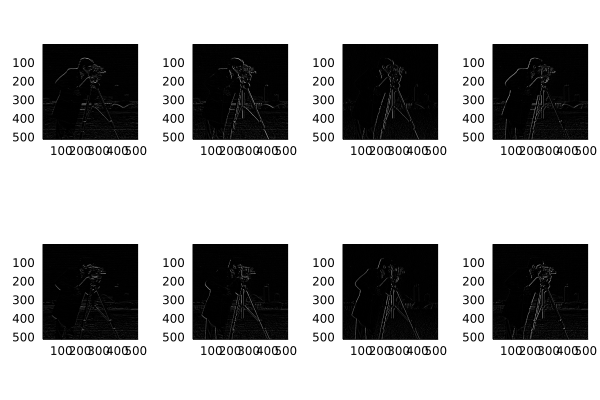

In [7]:
k_1 = OffsetArrays.centered([1 2 1; 0 0 0; -1 -2 -1]) # |
k_2 = OffsetArrays.centered([0 1 2; -1 0 1; -2 -1 0]) # /
k_3 = OffsetArrays.centered([-1 0 1; -2 0 2; -1 0 1]) # -
k_4 = OffsetArrays.centered([2 1 0; 1 0 -1; 0 -1 -2]) # \

img_1_pos, img_1_neg = filter_image(img, k_1)
img_2_pos, img_2_neg = filter_image(img, k_2)
img_3_pos, img_3_neg = filter_image(img, k_3)
img_4_pos, img_4_neg = filter_image(img, k_4)

p1 = plot(img_1_pos, label=false)
p2 = plot(img_2_pos, label=false)
p3 = plot(img_3_pos, label=false)
p4 = plot(img_4_pos, label=false)

p5 = plot(img_1_neg, label=false)
p6 = plot(img_2_neg, label=false)
p7 = plot(img_3_neg, label=false)
p8 = plot(img_4_neg, label=false)

plot(p1, p2, p3, p4, p5, p6, p7, p8, layout=(2, 4))


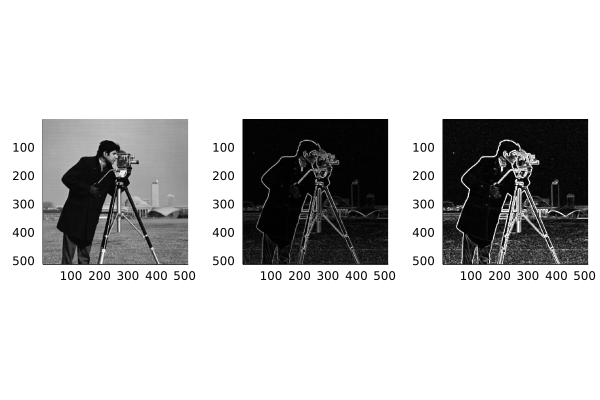

In [4]:
img_max = max.(img_1_pos, img_2_pos, img_3_pos, img_4_pos, img_1_neg, img_2_neg, img_3_neg, img_4_neg)
img_sum = img_1_pos .+ img_2_pos .+ img_3_pos .+ img_4_pos .+ img_1_neg .+ img_2_neg .+ img_3_neg .+ img_4_neg

plot(
    plot(img, label=false),
    plot(Gray.(img_max), label=false), 
    plot(Gray.(img_sum), label=false), layout=(1, 3)
)

## Description
Local edge filters with selectivity for different contrast orientations are implemented by 4 kernels each. Sum of each responses in the 8 output channels are compared with the input image.


# Exercise 2.1
# Code

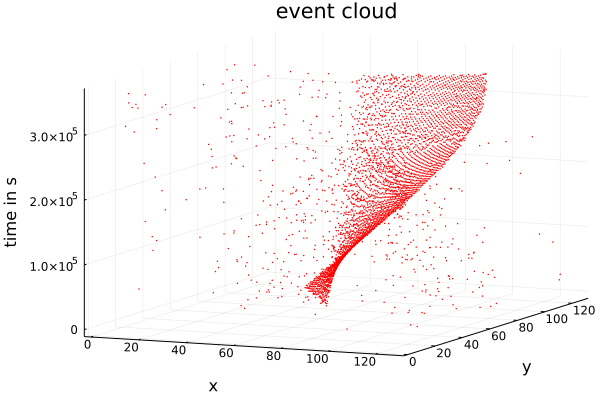

In [10]:
@load("sampleAERonlyOn.jld2")
scatter3d(x_coords, y_coords, allTs, markersize=1.0, markercolor=:red, markerstrokewidth=0, label=false,xlabel = "x",ylabel = "y",zlabel = "time in s", title="event cloud")


## Description
The figure shows all events where a pixel has changed over the time on the z axis. This visualizes the motion of the object.


# Exercise 2.2

┌ Info: Saved animation to 
│   fn = /Users/lukas/Documents/Uni/Semester_2/ViMaM/Exercises/Exercise1/material/tmp.gif
└ @ Plots /Users/lukas/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/Users/lukas/Documents/Uni/Semester_2/ViMaM/Exercises/Exercise1/material/tmp.gif")
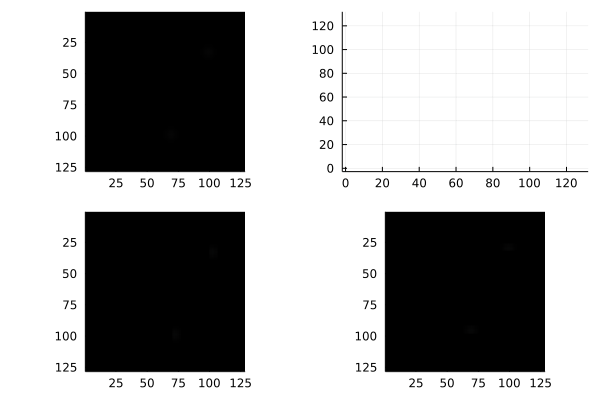

In [11]:
function rescale_vals(mat, val=5)
    mat .*= val
    return mat
end

n_events = length(x_coords)

mhi = zeros(128, 128)
mhi[x_coords[1], y_coords[1]] += 1
anim = @animate for i in 2:n_events
    # Update the mhi such that mhi(t) = max(0, mhi(told) − (t − told) · f),
    # where t is the current timestamp and told is the time stamp of the event
    # processed in the previous iteration and f = 0.00001
    @. mhi = max(0, mhi - (allTs[i] - allTs[i-1]) * 0.00001)

    # Increase mhi by one at the location of the currently processed event
    mhi[x_coords[i], y_coords[i]] += 1

    mhi_filtered = imfilter(mhi, Kernel.gaussian(3))
    
    sobel_x = imfilter(Gray.(mhi_filtered), reflect(k_3))
    sobel_y = imfilter(Gray.(mhi_filtered), reflect(k_1))
    
    Gx = rescale_vals(imfilter(sobel_x, reflect(k_3)))
    Gy = rescale_vals(imfilter(sobel_y, reflect(k_1)))
    
    # get magnitude of gradient vectors
    Gmag = sqrt.(Gx.^2 .+ Gy.^2)
    rows, cols = size(Gmag)
    for j = 1:cols
        for i = 1:rows
            if Gmag[i,j] < 1
                Gmag[i,j] = 0
            end
        end
    end
    
    # plot frames of gif
    p_mhi_1 = plot(Gray.(mhi_filtered), label="false")
    p_mhi_h = plot(Gray.(sobel_x), label="false")
    p_mhi_v = plot(Gray.(sobel_y), label="false")
    
    p_mhi_grad = quiver(
        x_coords[1:10:n_events],
        y_coords[1:10:n_events], 
        quiver=(Gx[1:10:n_events], Gy[1:10:n_events])
    )
    plot(p_mhi_1, p_mhi_grad, p_mhi_h, p_mhi_v, layout=(2, 2))
end every 50

gif(anim, fps=30)

# Description
The subplots are showing an anmination of the events from the event cloud. The upper left plot shows the all currently occuring events. The events are fading out over time. This is called motion history image. The lower left plot filters the motion history image for the vertical contrast changes. The lower right plot shows the horizontal edges.

The motion directions are used in the upper right plot to visualize the estimated motion direction as vectors.